## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import seaborn as sns
warnings.simplefilter("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from datetime import datetime

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Daily

We first try and make predictions from the data where we get daily temperature predictions. <br>
We also scale the number of calls made on a daily basis, by simply dividing it by 100.

In [2]:
df =  pd.read_csv('engineered_dataset_with_wind.csv')
df['Count'] = df['Count'] / 100

In [3]:
df

,Date,Count,DailyMeanTemp,DailyTempStd,WindSpeedMean,WindSpeedStd
0,2016-01-01,27.80,41.250000,0.758068,6.950000,5.291755
1,2016-01-02,30.60,36.700000,0.700476,7.350000,5.628736
2,2016-01-03,30.95,38.850000,1.294218,6.950000,5.036434
3,2016-01-04,59.63,32.200000,1.141490,8.650000,6.466838
4,2016-01-05,81.11,19.000000,0.430891,8.850000,6.807178
...,...,...,...,...,...,...
1091,2018-12-27,47.33,47.500116,12.504621,8.197538,2.853350
1092,2018-12-28,42.94,47.500168,12.604379,8.204367,2.855998
1093,2018-12-29,34.92,47.500127,12.703358,8.198090,2.858558
1094,2018-12-30,35.00,47.500159,12.801569,8.203860,2.861195


We look at the distribution of the number of calls on a daily basis and notice an increasing pattern.
We also perform an Augmented Dickey Fuller test

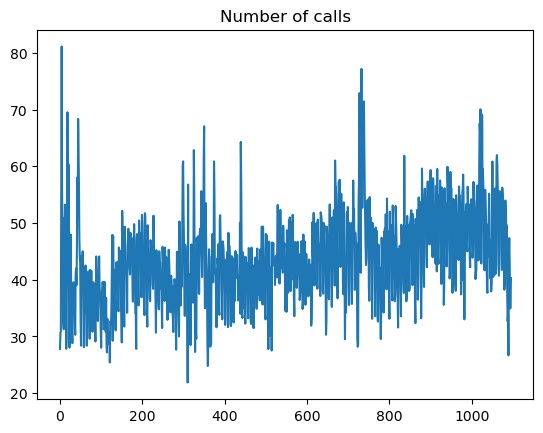

ADF Statistic on the entire dataset: -3.6386591530230654
p-value: 0.005063533944580202
Critical Values:
	1%: -3.4364533503600962
	5%: -2.864234857527328
	10%: -2.568204837482531


In [4]:
train_portion = df

plt.plot(train_portion['Count'])
plt.title('Number of calls')
plt.show()

result = adfuller(train_portion['Count'])
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

We take the first difference and then plot the distribution. We also perform the ADF test and notice a much smaller p-value

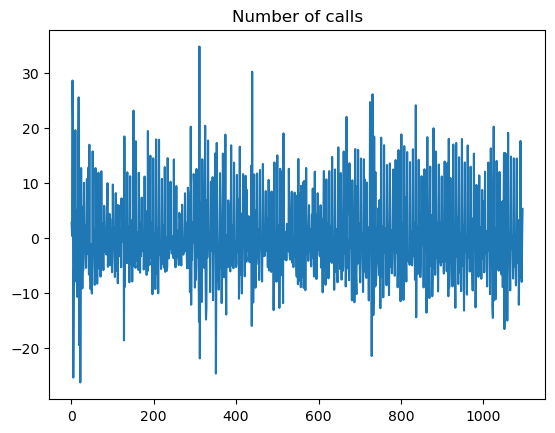

ADF Statistic on the entire dataset: -10.984544893994842
p-value: 7.315291020879029e-20
Critical Values:
	1%: -3.4364533503600962
	5%: -2.864234857527328
	10%: -2.568204837482531


In [5]:
num_calls_first_diff = train_portion['Count'].diff()[1:]

plt.plot(num_calls_first_diff)
plt.title('Number of calls')
plt.show()

result = adfuller(num_calls_first_diff)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

We find the values for p and q using the PACF and ACF plots

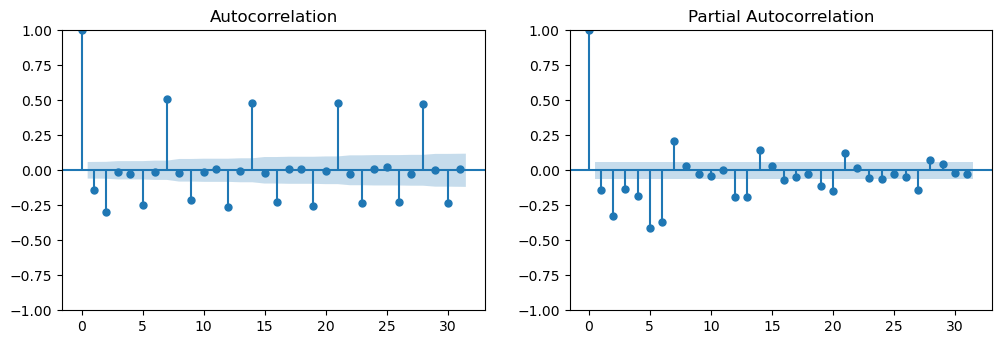

In [6]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,2,1)
fig = sm.graphics.tsa.plot_acf(num_calls_first_diff, ax=ax1)
ax2 = fig.add_subplot(2,2,2)
fig = sm.graphics.tsa.plot_pacf(num_calls_first_diff, ax=ax2)

We now fit a time series model - ARIMA with cross validation and without any exogenous variables to get a baseline estimate.

In [7]:
# train_portion['Count'] = train_portion['Count'].diff()[1:]

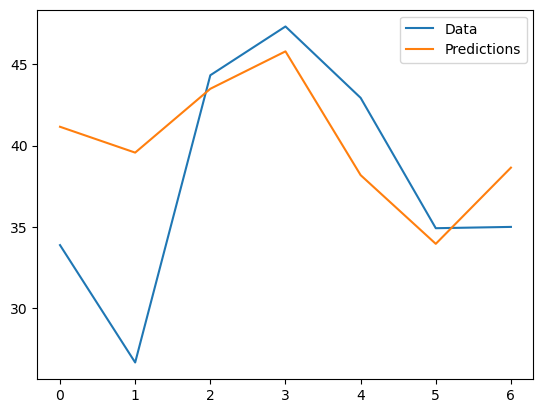

Average RMSE: 58.72902476364662
Average MAPE: 0.11656137396257574
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                 1088
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -3409.062
Date:                Sun, 25 Dec 2022   AIC                           6838.124
Time:                        08:51:54   BIC                           6888.036
Sample:                             0   HQIC                          6857.017
                               - 1088                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8675      0.045    -19.212      0.000      -0.956      -0.779
ar.L2         -1.3191      0.042    -31.160      0.000      -1.40

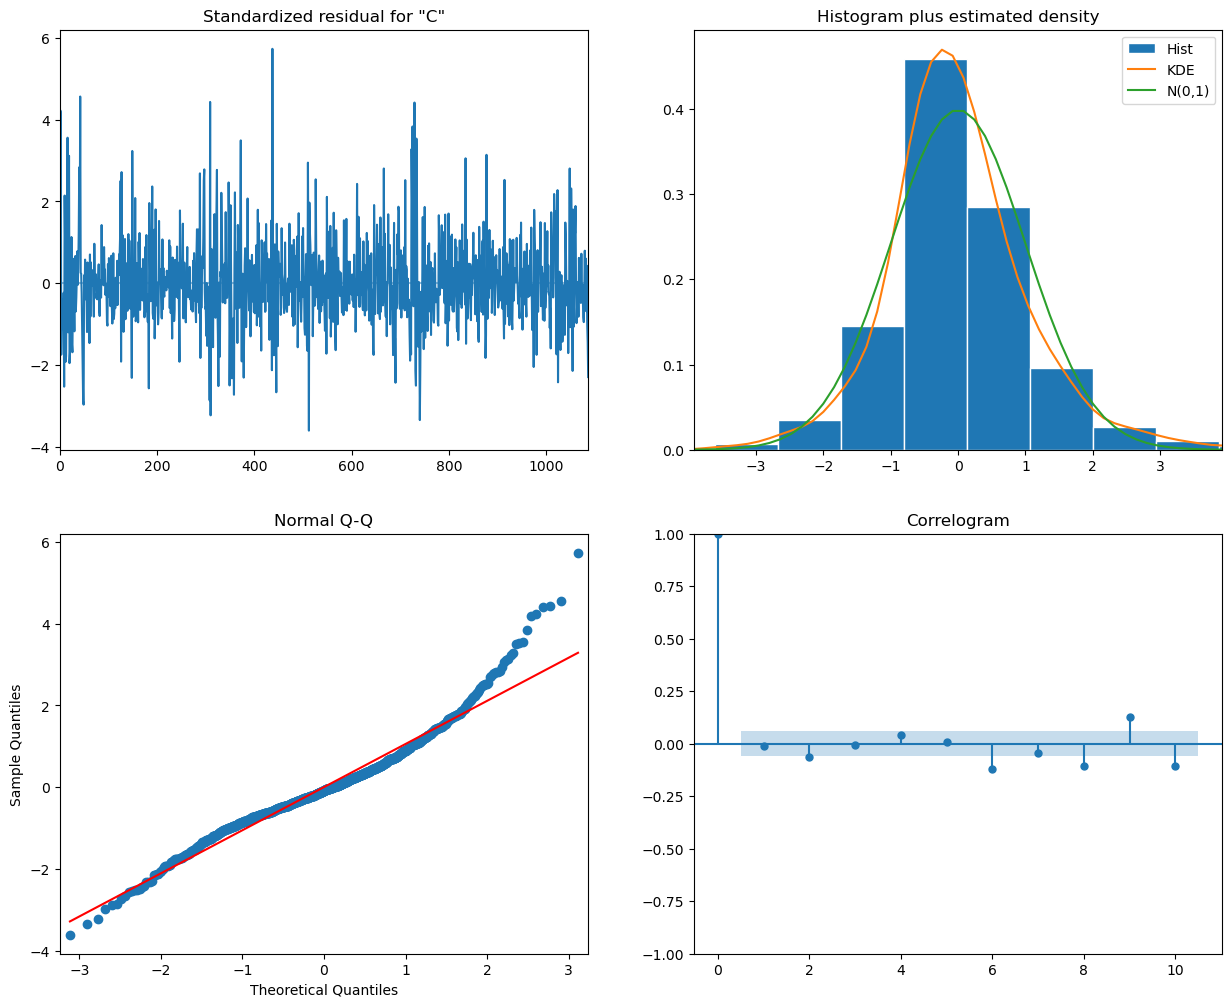

In [8]:
num_folds = 5

rmse = []
mape = []
for j in range(num_folds):
    train_data = train_portion['Count'][1:-(7 * (num_folds-j))]
    val_data = train_portion['Count'][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    model = ARIMA(train_data, order = (7,1,2))
    model_fit = model.fit(method_kwargs={"warn_convergence": False})
    
    predictions = model_fit.get_forecast(7)

    prediction = predictions.predicted_mean
    prediction_range = predictions.conf_int(alpha=0.05)
    deviation = (prediction - prediction_range.iloc[:,-1])/2

    rmse.append(mean_squared_error(prediction, list(val_data)))
    mape.append(mean_absolute_percentage_error(prediction, list(val_data)))

rmse = np.array(rmse)
mape = np.array(mape)

plt.plot(range(len(val_data)), val_data.values)
plt.plot(range(len(val_data)), prediction.values)
plt.legend(('Data', 'Predictions'))
plt.show()

model_fit.plot_diagnostics(figsize=(15, 12))

print(f'Average RMSE: {np.mean(rmse)}')
print(f'Average MAPE: {np.mean(mape)}')
print(model_fit.summary())

print()


We now incorporate the daily temperature as an exogenous variable and observe a smaller AIC score. The p-value for the feature is also < 0.05, implying that temperature is a statistically significant feature.

/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/

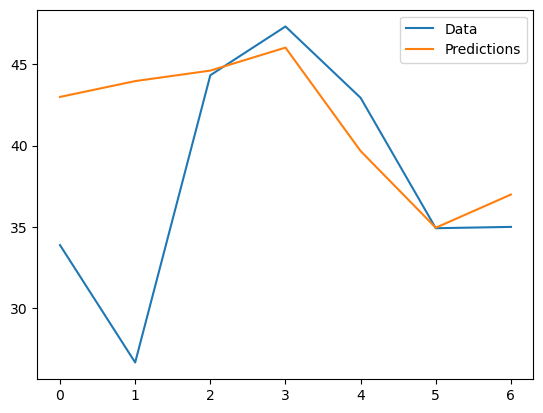

Average RMSE: 60.78388703126707
Average MAPE: 0.11330282979454889
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                 1088
Model:               SARIMAX(7, 1, 2)   Log Likelihood               -3394.033
Date:                Sun, 25 Dec 2022   AIC                           6810.065
Time:                        08:52:02   BIC                           6864.968
Sample:                             0   HQIC                          6830.848
                               - 1088                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
DailyMeanTemp    -0.1718      0.022     -7.962      0.000      -0.214      -0.130
ar.L1            -0.7763      0.205     -3.783      0.00

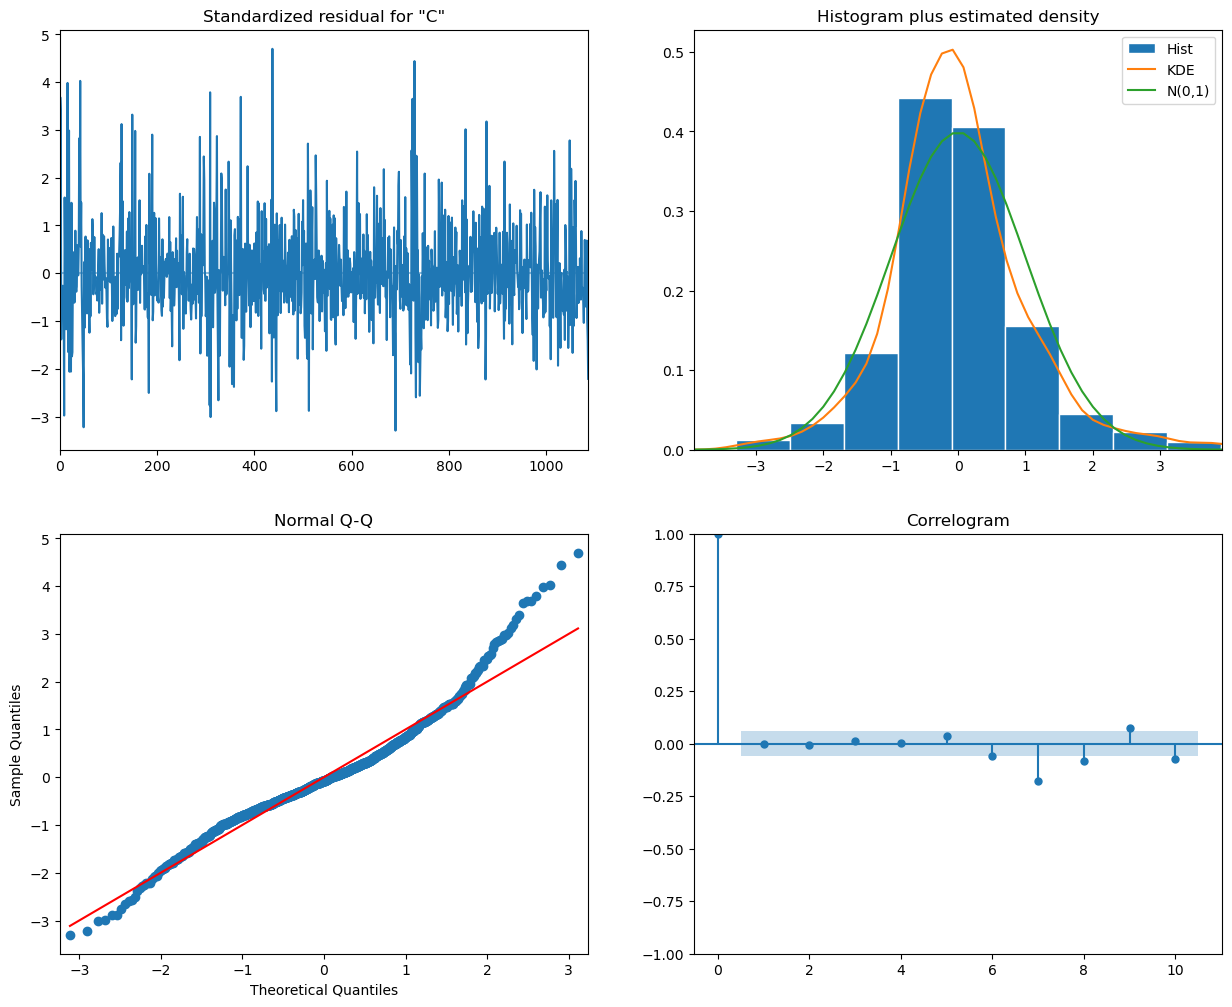

In [9]:
num_folds = 5

rmse = []
mape = []
for j in range(num_folds):
    train_data = train_portion['Count'][1:-(7 * (num_folds-j))]
    val_data = train_portion['Count'][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    exog_train = train_portion['DailyMeanTemp'][1:-(7 * (num_folds-j))]
    exog_val = train_portion['DailyMeanTemp'][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    model = SARIMAX(train_data, exog_train, order = (7,1,2))
    model_fit = model.fit(method_kwargs={"warn_convergence": False}, disp=False)
    
    predictions = model_fit.get_forecast(7, exog = exog_val)

    prediction = predictions.predicted_mean
    prediction_range = predictions.conf_int(alpha=0.05)
    deviation = (prediction - prediction_range.iloc[:,-1])/2

    rmse.append(mean_squared_error(prediction, list(val_data)))
    mape.append(mean_absolute_percentage_error(prediction, list(val_data)))


rmse = np.array(rmse)
mape = np.array(mape)

plt.plot(range(len(val_data)), val_data.values)
plt.plot(range(len(val_data)), prediction.values)
plt.legend(('Data', 'Predictions'))
plt.show()

model_fit.plot_diagnostics(figsize=(15, 12))

print(f'Average RMSE: {np.mean(rmse)}')
print(f'Average MAPE: {np.mean(mape)}')
print(model_fit.summary())

print()
print()


We now incorporate the daily temperature and its standard deviation as exogenous variables and observe an even smaller AIC score. The p-value for the feature is also < 0.05, implying that temperature and its standard deviation are statistically significant features.

/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


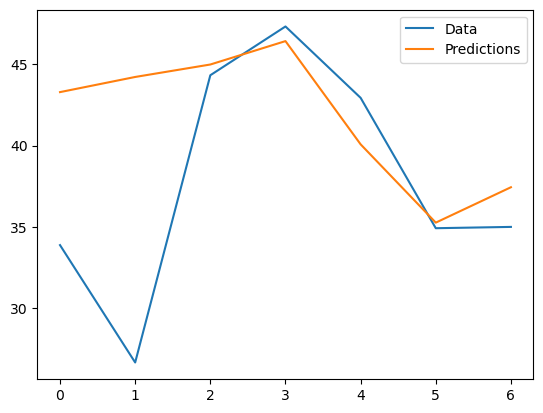

Average RMSE: 61.690386131340915
Average MAPE: 0.11477821519608825
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                 1088
Model:               SARIMAX(7, 1, 2)   Log Likelihood               -3389.839
Date:                Sun, 25 Dec 2022   AIC                           6803.678
Time:                        08:52:08   BIC                           6863.572
Sample:                             0   HQIC                          6826.350
                               - 1088                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
DailyMeanTemp    -0.1978      0.022     -8.986      0.000      -0.241      -0.155
DailyTempStd      0.5936      0.238      2.498      0.0

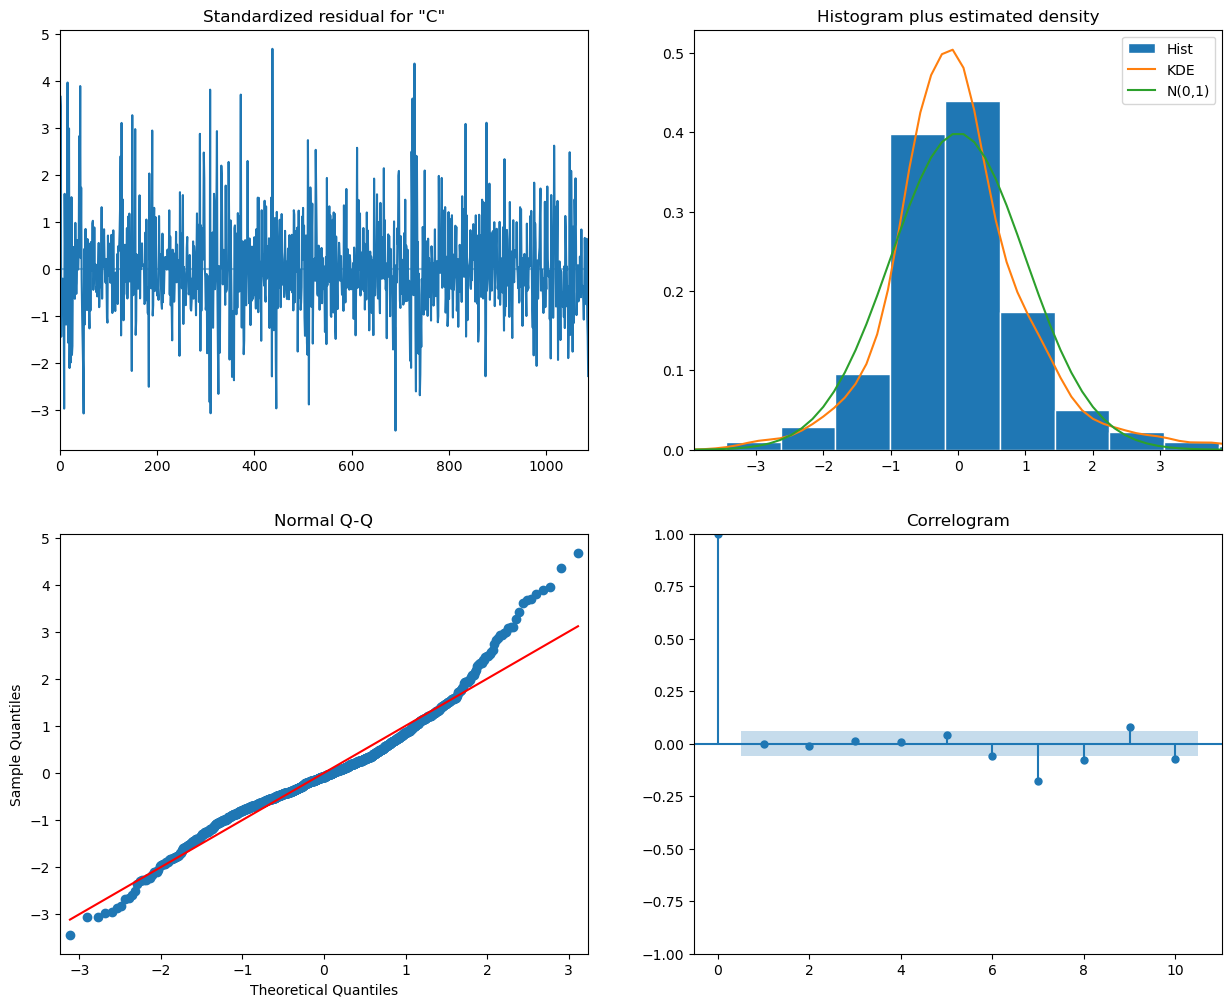

In [10]:
num_folds = 5

rmse = []
mape = []
for j in range(num_folds):
    train_data = train_portion['Count'][1:-(7 * (num_folds-j))]
    val_data = train_portion['Count'][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    exog_train = train_portion[['DailyMeanTemp', 'DailyTempStd']][1:-(7 * (num_folds-j))]
    exog_val = train_portion[['DailyMeanTemp', 'DailyTempStd']][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    model = SARIMAX(train_data, exog_train, order = (7,1,2))
    model_fit = model.fit(method_kwargs={"warn_convergence": False}, disp=False)
    
    predictions = model_fit.get_forecast(7, exog = exog_val)

    prediction = predictions.predicted_mean
    prediction_range = predictions.conf_int(alpha=0.05)
    deviation = (prediction - prediction_range.iloc[:,-1])/2

    rmse.append(mean_squared_error(prediction, list(val_data)))
    mape.append(mean_absolute_percentage_error(prediction, list(val_data)))


rmse = np.array(rmse)
mape = np.array(mape)

plt.plot(range(len(val_data)), val_data.values)
plt.plot(range(len(val_data)), prediction.values)
plt.legend(('Data', 'Predictions'))
plt.show()

model_fit.plot_diagnostics(figsize=(15, 12))

print(f'Average RMSE: {np.mean(rmse)}')
print(f'Average MAPE: {np.mean(mape)}')
print(model_fit.summary())

print()
print()


We do the same thing as before and now add wind speed, its standard deviation. This further decreases the AIC value and the p-value for all features are less than 0.05, implying they are statistically significant.

/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/

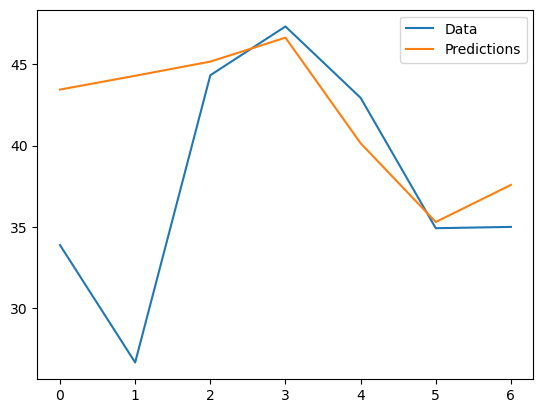

Average RMSE: 63.156822605671366
Average MAPE: 0.11511667933766959
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                 1088
Model:               SARIMAX(7, 1, 2)   Log Likelihood               -3374.045
Date:                Sun, 25 Dec 2022   AIC                           6776.090
Time:                        08:52:15   BIC                           6845.967
Sample:                             0   HQIC                          6802.540
                               - 1088                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
DailyMeanTemp    -0.1859      0.023     -8.227      0.000      -0.230      -0.142
DailyTempStd      0.7932      0.231      3.429      0.0

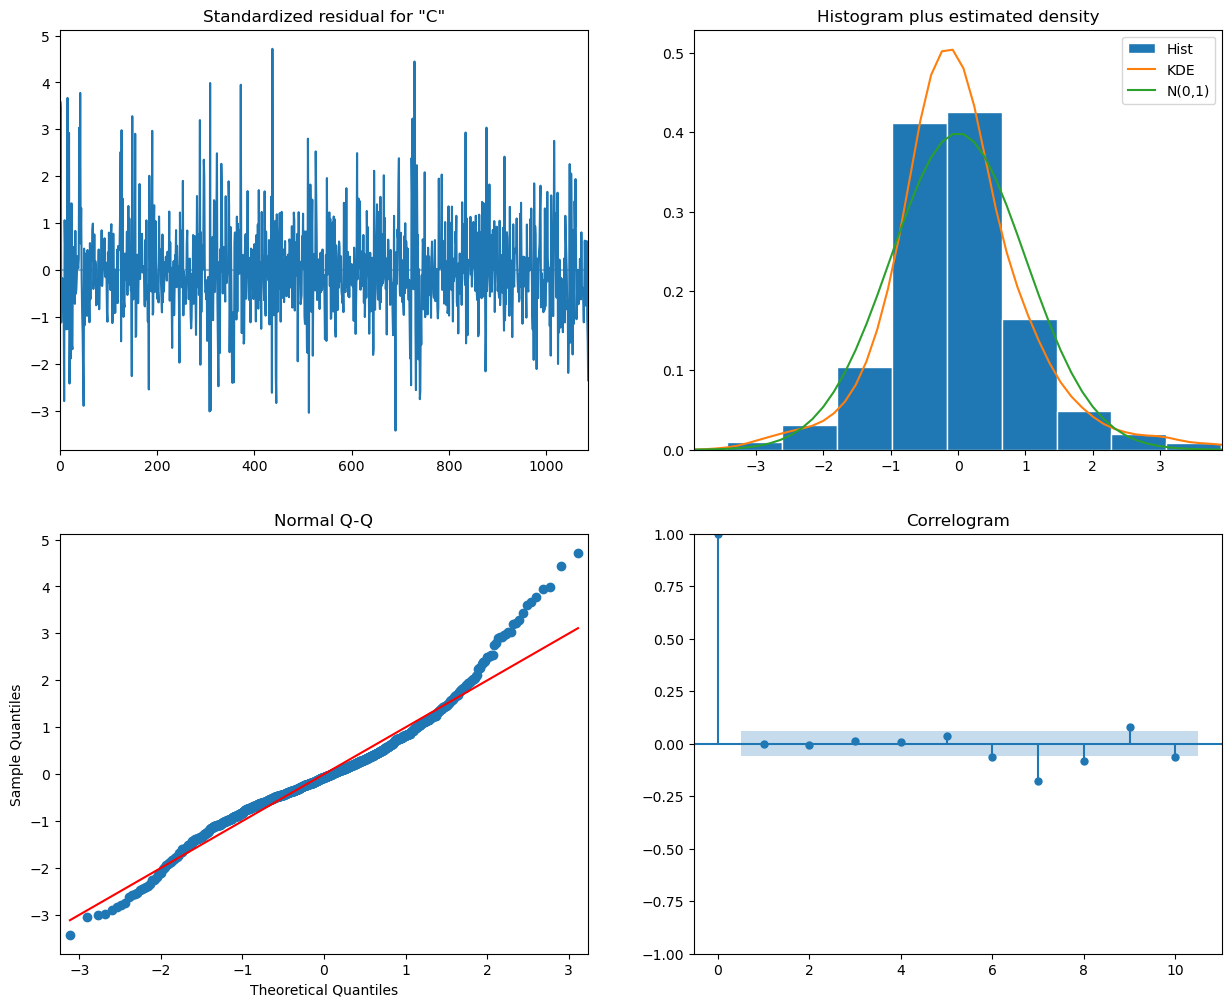

In [11]:
num_folds = 5

rmse = []
mape = []
for j in range(num_folds):
    train_data = train_portion['Count'][1:-(7 * (num_folds-j))]
    val_data = train_portion['Count'][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    exog_train = train_portion[['DailyMeanTemp', 'DailyTempStd', 'WindSpeedMean', 'WindSpeedStd']][1:-(7 * (num_folds-j))]
    exog_val = train_portion[['DailyMeanTemp', 'DailyTempStd', 'WindSpeedMean', 'WindSpeedStd']][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    model = SARIMAX(train_data, exog_train, order = (7,1,2))
    model_fit = model.fit(method_kwargs={"warn_convergence": False}, disp=False)
    
    predictions = model_fit.get_forecast(7, exog = exog_val)

    prediction = predictions.predicted_mean
    prediction_range = predictions.conf_int(alpha=0.05)
    deviation = (prediction - prediction_range.iloc[:,-1])/2

    rmse.append(mean_squared_error(prediction, list(val_data)))
    mape.append(mean_absolute_percentage_error(prediction, list(val_data)))


rmse = np.array(rmse)
mape = np.array(mape)

plt.plot(range(len(val_data)), val_data.values)
plt.plot(range(len(val_data)), prediction.values)
plt.legend(('Data', 'Predictions'))
plt.show()

model_fit.plot_diagnostics(figsize=(15, 12))

print(f'Average RMSE: {np.mean(rmse)}')
print(f'Average MAPE: {np.mean(mape)}')
print(model_fit.summary())

print()
print()


Making predictions for the next 7 days, by first fitting the model on the entire dataset


In [12]:
future = pd.read_csv('future_values.csv')

/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                 1096
Model:               SARIMAX(7, 1, 2)   Log Likelihood               -3404.316
Date:                Sun, 25 Dec 2022   AIC                           6836.631
Time:                        08:52:16   BIC                           6906.610
Sample:                             0   HQIC                          6863.111
                               - 1096                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
DailyMeanTemp    -0.1871      0.023     -8.236      0.000      -0.232      -0.143
DailyTempStd      0.8017      0.234      3.432      0.001       0.344       1.260
WindSpeedMean    -0.1307      0.114     

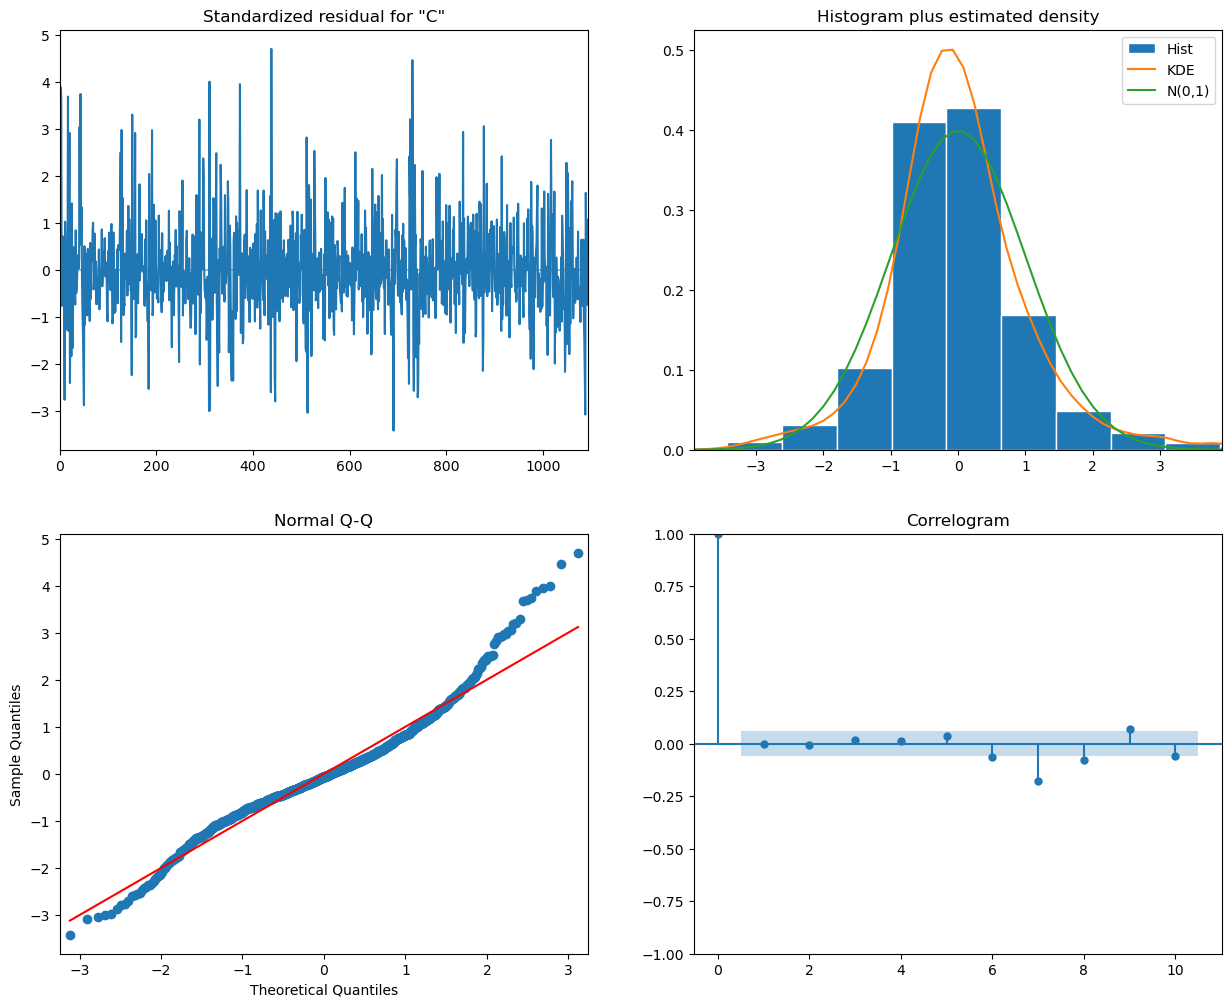

In [13]:
train_data = train_portion['Count']
exog_train = train_portion[['DailyMeanTemp', 'DailyTempStd', 'WindSpeedMean', 'WindSpeedStd']]

model = SARIMAX(train_data, exog_train, order = (7,1,2))
model_fit = model.fit(method_kwargs={"warn_convergence": False}, disp=False)

predictions = model_fit.get_forecast(7, exog = future.iloc[-7:])

predictionb = predictions.predicted_mean
prediction_range = predictions.conf_int(alpha=0.05)
deviation = (prediction - prediction_range.iloc[:,-1])/2

model_fit.plot_diagnostics(figsize=(15, 12))
print(model_fit.summary())


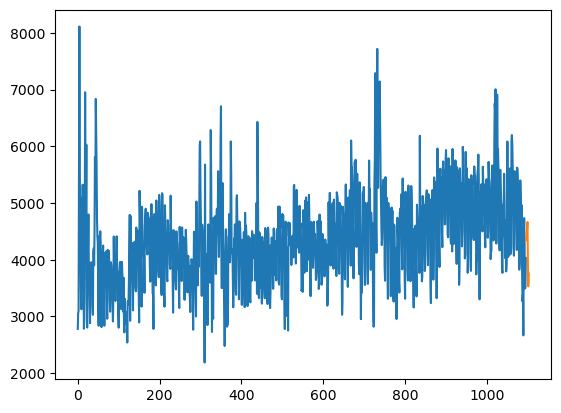

In [14]:
plt.plot(list(range(len(train_data))), list(train_data * 100))
plt.plot(list(range(len(train_data),len(train_data) + 7)), prediction*100)

Predictions from the model

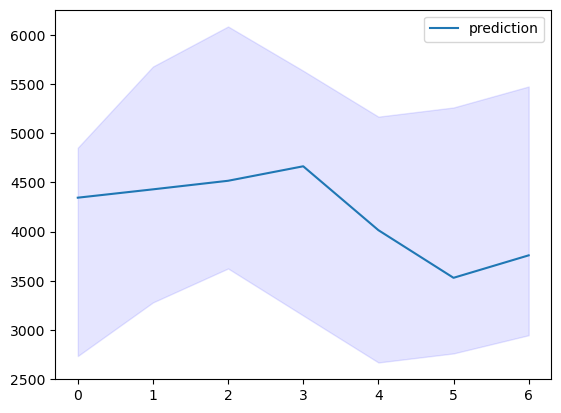

In [15]:
plt.plot(list(range(0, 7)), prediction*100, label = 'prediction')
plt.fill_between(list(range(0, 7)), prediction_range.iloc[:, 0].values * 100, prediction_range.iloc[:, 1].values * 100, color='b', alpha=.1)
plt.legend()

## Weekly

We adopt a similar technique here where we work off of the dataset with predictions made for temperature on a weekly basis. Owing to the bad results and very high AIC values, we discontinue this experiment and not explore further down this lane.

In [16]:
df =  pd.read_csv('engineered_dataset_weekly.csv')

In [17]:
df['Count'] = df['Count'] / 100

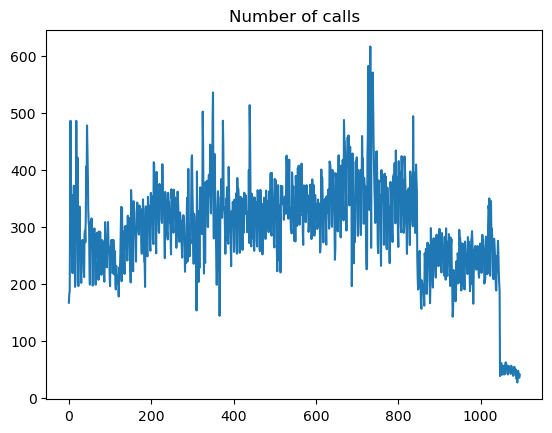

ADF Statistic on the entire dataset: -0.7693809426052042
p-value: 0.8279511701682392
Critical Values:
	1%: -3.4364533503600962
	5%: -2.864234857527328
	10%: -2.568204837482531


In [18]:
train_portion = df

plt.plot(train_portion['Count'])
plt.title('Number of calls')
plt.show()

result = adfuller(train_portion['Count'])
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

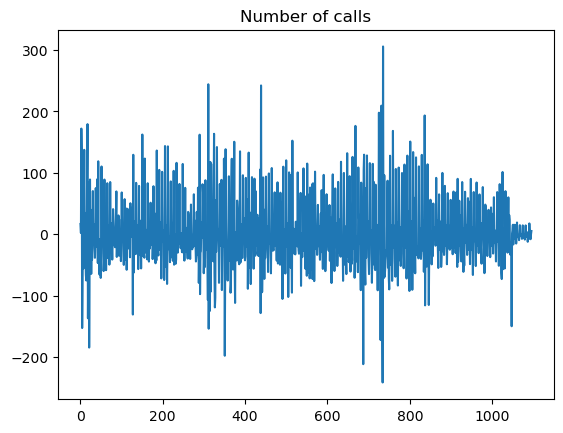

ADF Statistic on the entire dataset: -10.297695669367094
p-value: 3.436641182956808e-18
Critical Values:
	1%: -3.4364533503600962
	5%: -2.864234857527328
	10%: -2.568204837482531


In [19]:
num_calls_first_diff = train_portion['Count'].diff()[1:]

plt.plot(num_calls_first_diff)
plt.title('Number of calls')
plt.show()

result = adfuller(num_calls_first_diff)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

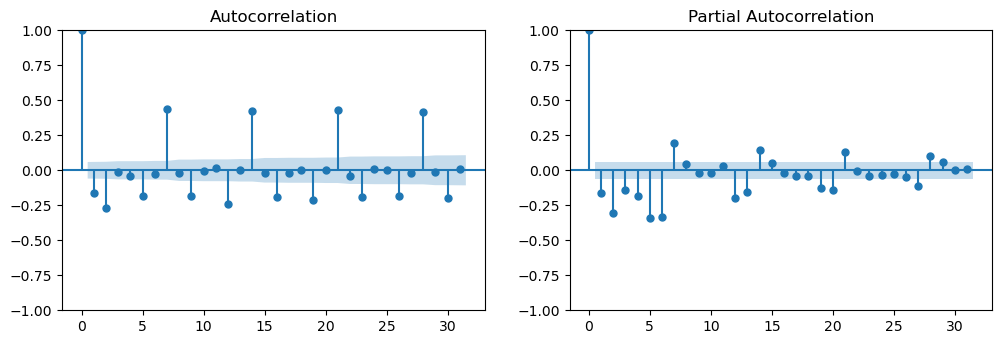

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,2,1)
fig = sm.graphics.tsa.plot_acf(num_calls_first_diff, ax=ax1)
ax2 = fig.add_subplot(2,2,2)
fig = sm.graphics.tsa.plot_pacf(num_calls_first_diff, ax=ax2)

In [21]:
train_portion

,YearWeek,Count,Date,WeekMeanTemp,WeekTempStd
0,201600,166.80,2016-01-01,39.000000,2.501030
1,201600,183.60,2016-01-02,39.000000,2.501030
2,201601,185.70,2016-01-03,36.800000,7.771757
3,201601,357.78,2016-01-04,36.800000,7.771757
4,201601,486.66,2016-01-05,36.800000,7.771757
...,...,...,...,...,...
1091,201851,47.33,2018-12-27,33.853557,5.144074
1092,201851,42.94,2018-12-28,33.853557,5.144074
1093,201851,34.92,2018-12-29,33.853557,5.144074
1094,201852,35.00,2018-12-30,33.068500,5.202969


/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/

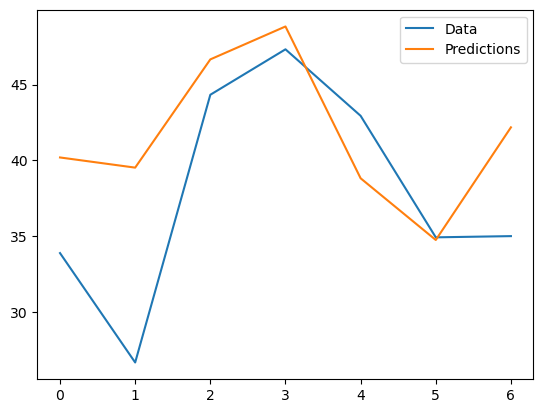

Average RMSE: 120.3056486501325
Average MAPE: 0.1727053736385447
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                 1088
Model:               SARIMAX(7, 1, 2)   Log Likelihood               -5632.076
Date:                Sun, 25 Dec 2022   AIC                          11286.153
Time:                        08:52:22   BIC                          11341.056
Sample:                             0   HQIC                         11306.935
                               - 1088                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
WeekMeanTemp    -2.3589      0.391     -6.033      0.000      -3.125      -1.593
ar.L1           -0.8080      0.035    -23.323      0.000    

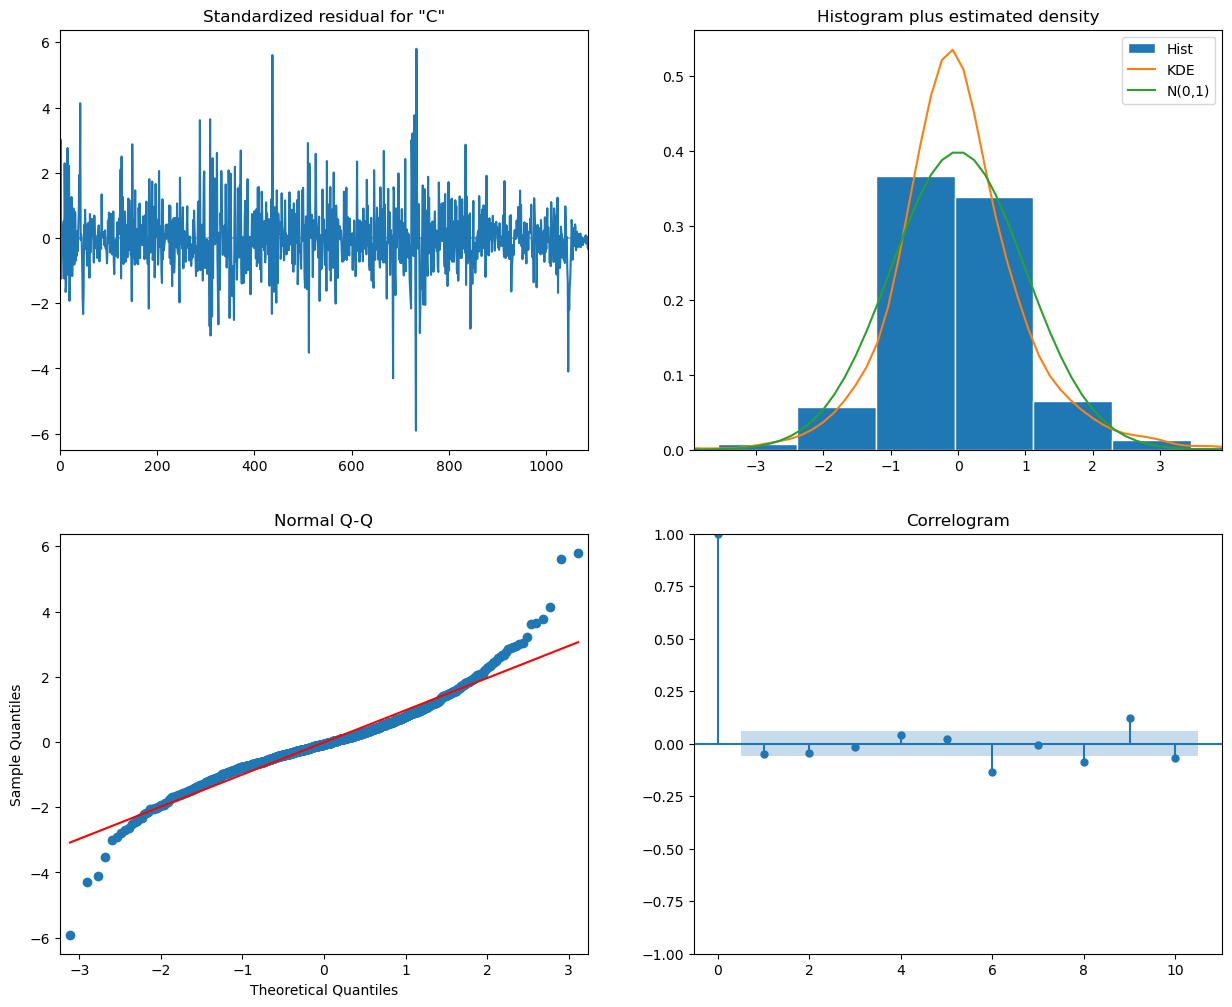

In [22]:
num_folds = 5

rmse = []
mape = []
for j in range(num_folds):
    train_data = train_portion['Count'][1:-(7 * (num_folds-j))]
    val_data = train_portion['Count'][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    exog_train = train_portion['WeekMeanTemp'][1:-(7 * (num_folds-j))]
    exog_val = train_portion['WeekMeanTemp'][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    model = SARIMAX(train_data, exog_train, order = (7,1,2))
    model_fit = model.fit(method_kwargs={"warn_convergence": False}, disp=False)
    
    predictions = model_fit.get_forecast(7, exog = exog_val)

    prediction = predictions.predicted_mean
    prediction_range = predictions.conf_int(alpha=0.05)
    deviation = (prediction - prediction_range.iloc[:,-1])/2

    rmse.append(mean_squared_error(prediction, list(val_data)))
    mape.append(mean_absolute_percentage_error(prediction, list(val_data)))


rmse = np.array(rmse)
mape = np.array(mape)

plt.plot(range(len(val_data)), val_data.values)
plt.plot(range(len(val_data)), prediction.values)
plt.legend(('Data', 'Predictions'))
plt.show()

model_fit.plot_diagnostics(figsize=(15, 12))

print(f'Average RMSE: {np.mean(rmse)}')
print(f'Average MAPE: {np.mean(mape)}')
print(model_fit.summary())

print()
print()

/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pranavkarnani/miniconda3/

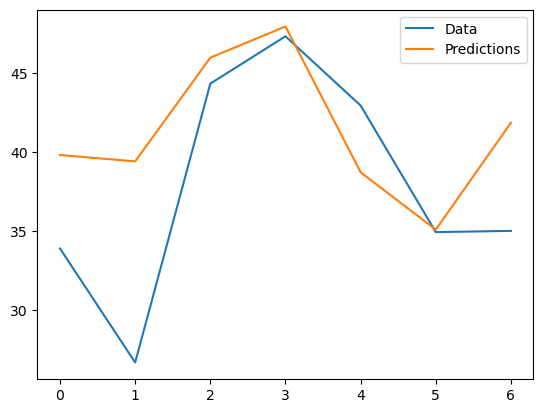

Average RMSE: 123.98396279926155
Average MAPE: 0.17532850380286638
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                 1088
Model:               SARIMAX(7, 1, 2)   Log Likelihood               -5626.642
Date:                Sun, 25 Dec 2022   AIC                          11277.285
Time:                        08:52:29   BIC                          11337.179
Sample:                             0   HQIC                         11299.956
                               - 1088                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
WeekMeanTemp    -2.0375      0.405     -5.034      0.000      -2.831      -1.244
WeekTempStd      2.1406      0.871      2.459      0.014  

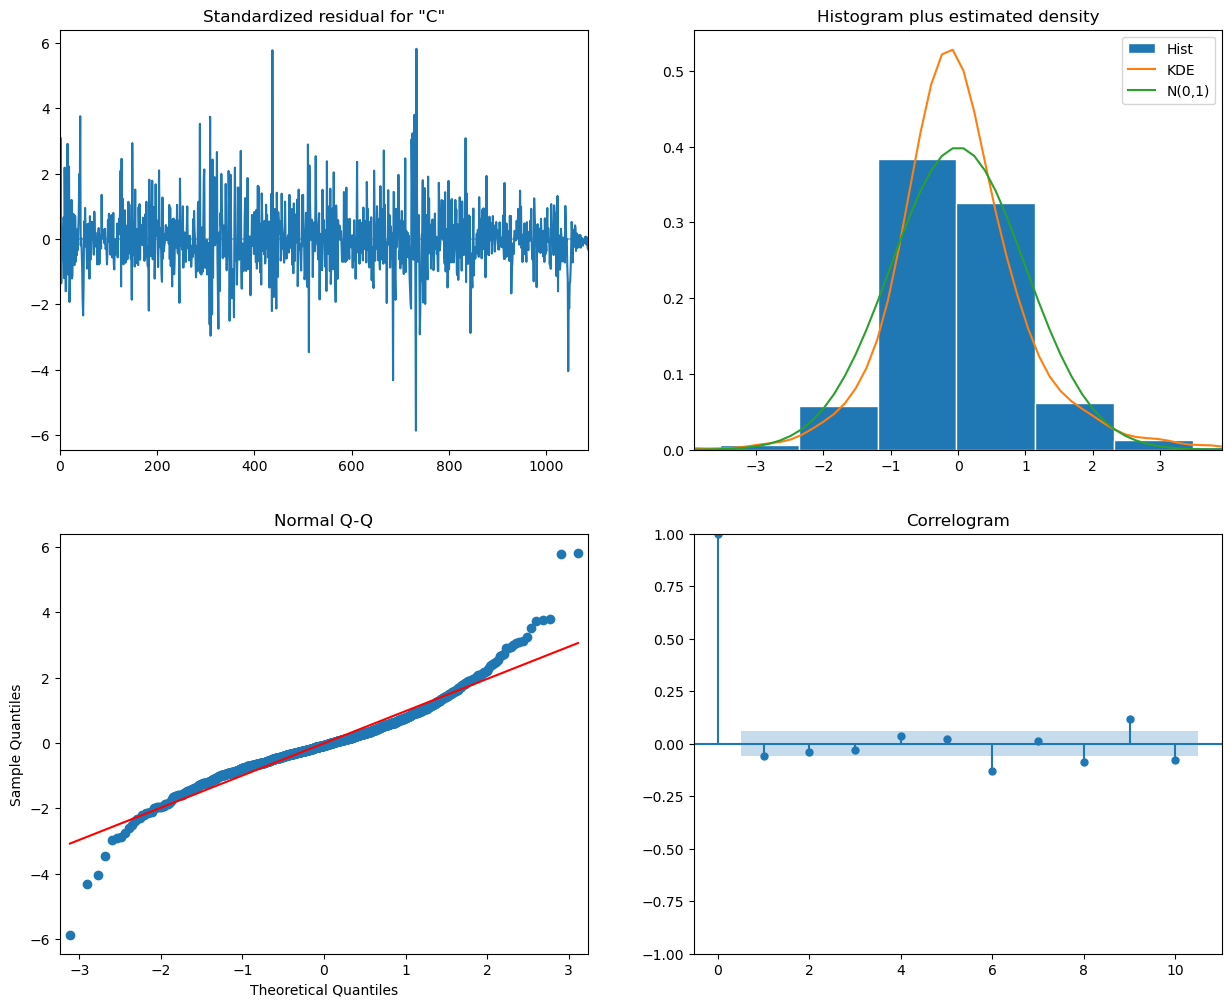

In [23]:
num_folds = 5

rmse = []
mape = []
for j in range(num_folds):
    train_data = train_portion['Count'][1:-(7 * (num_folds-j))]
    val_data = train_portion['Count'][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    exog_train = train_portion[['WeekMeanTemp', 'WeekTempStd']][1:-(7 * (num_folds-j))]
    exog_val = train_portion[['WeekMeanTemp', 'WeekTempStd']][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

    model = SARIMAX(train_data, exog_train, order = (7,1,2))
    model_fit = model.fit(method_kwargs={"warn_convergence": False}, disp=False)
    
    predictions = model_fit.get_forecast(7, exog = exog_val)

    prediction = predictions.predicted_mean
    prediction_range = predictions.conf_int(alpha=0.05)
    deviation = (prediction - prediction_range.iloc[:,-1])/2

    rmse.append(mean_squared_error(prediction, list(val_data)))
    mape.append(mean_absolute_percentage_error(prediction, list(val_data)))


rmse = np.array(rmse)
mape = np.array(mape)

plt.plot(range(len(val_data)), val_data.values)
plt.plot(range(len(val_data)), prediction.values)
plt.legend(('Data', 'Predictions'))
plt.show()

model_fit.plot_diagnostics(figsize=(15, 12))

print(f'Average RMSE: {np.mean(rmse)}')
print(f'Average MAPE: {np.mean(mape)}')
print(model_fit.summary())

print()
print()